<div align="center">

# **Implementing Reinforcement Learning Agents with Stable-Baselines3**

### **Academic Year: 2025 / 2026**

---

### **Group Members**

| Name | Student Number |
|------|----------------|
| João Pedro Nunes Rocha | up202306599 |
| Paulo Diogo Lopes Pinto | up202306412 |
| Rui Filipe Rocha Alvarilhão | up202209989 |

---

_Faculdade de Ciências da Universidade do Porto (FCUP)_  
_Licenciatura em Inteligência Artificial e Ciência de Dados (IACD)_

</div>

# Introdução

Escrever uma introdução

In [1]:
# 1. Standard Library Imports
import os
import csv

# 2. Third-Party Data & Visualization Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image, display

# 3. Gymnasium & ALE (Atari) Imports
import gymnasium as gym
import ale_py
from gymnasium import spaces

# 4. Stable Baselines3 Imports
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
from stable_baselines3.common.monitor import Monitor


from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, SubprocVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
import os

from stable_baselines3.common.callbacks import EvalCallback
from sb3_contrib import QRDQN

# 1) Seleção do Ambiente: Assault


Para este trabalho de aprendizagem por reforço, foi escolhido o ambiente **Assault** da suite Atari disponível no Gymnasium. Assault é um jogo arcade clássico onde o agente controla um veículo na parte inferior do ecrã que deve destruir naves espaciais inimigas enquanto evita os seus projéteis. Este ambiente apresenta um desafio interessante para agentes de RL devido à sua natureza dinâmica, exigindo tanto **estratégias ofensivas** (destruir inimigos) como **manobras defensivas** (esquivar-se de ataques). O sistema de pontuação do jogo, os padrões de movimento dos inimigos e a mecânica dos projéteis oferecem múltiplas oportunidades para personalizações significativas que podem impactar substancialmente a aprendizagem e o desempenho do agente. Adicionalmente, o facto de a arma poder sofrer **overheat** caso o agente dispare continuamente torna-se um desafio particularmente interessante, obrigando o agente a equilibrar a agressividade com a **gestão de recursos e timing estratégico**. A complexidade visual e os requisitos de tomada de decisão em tempo real tornam-no um ambiente ideal para avaliar como as modificações ambientais afetam a capacidade do agente de desenvolver políticas eficazes.

In [2]:
# Regista os ambientes Atari (ALE) no Gymnasium
gym.register_envs(ale_py)

# Cria o ambiente Assault da suite Atari
env = gym.make("ALE/Assault-v5", render_mode="rgb_array")
print("Ambiente Assault carregado com sucesso!")

Ambiente Assault carregado com sucesso!


A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


# 2) Wrappers Personalizados

Alguma cena a explicar o que são wrappers

## 2.1) Wrapper Visual

In [3]:
class AssaultVisualWrapper(gym.Wrapper):
    def __init__(self, env, noise_level=0):
        super().__init__(env)
        self.noise_level = noise_level
        old_shape = env.observation_space.shape
        new_shape = (old_shape[0], old_shape[1], 1)
        self.observation_space = spaces.Box(low=0, high=255, shape=new_shape, dtype=np.uint8)

    def _convert_to_grayscale(self, obs):
        gray = np.dot(obs[..., :3], [0.299, 0.587, 0.114])
        gray = np.expand_dims(gray, axis=-1)
        return gray.astype(np.uint8)

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        gray_obs = self._convert_to_grayscale(obs)
        noise = np.random.normal(0, self.noise_level, gray_obs.shape)
        noisy_obs = np.clip(gray_obs.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        return noisy_obs, reward, terminated, truncated, info

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        gray_obs = self._convert_to_grayscale(obs)
        noise = np.random.normal(0, self.noise_level, gray_obs.shape)
        noisy_obs = np.clip(gray_obs.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        return noisy_obs, info

## 2.2) CustomAssaultWrapper (sem Enemy Density Penalty)

escrever algo sobre o wrapper

In [ ]:
class CustomAssaultWrapper(gym.Wrapper):
    """
    Wrapper Personalizado para Assault (Atari).
    
    Modificações:
    1. State Space (Visual): Grayscale + Ruído.
    2. Rewards:
       - Living Penalty: -0.01 por frame.
       - Shooting Penalty: -0.5 por tiro.
       - Death Penalty: Penalidade grande ao perder uma vida.
       - Enemy Density Penalty: Penalidade baseada na quantidade de "coisas" na tela.
    """
    def __init__(self, env, noise_level=0, 
                 living_penalty=-0.05, 
                 shot_penalty=-0.5, 
                 death_penalty=-25,
                 density_penalty_factor=-0.0001):
        
        super().__init__(env)
        self.noise_level = noise_level
        self.living_penalty = living_penalty
        self.shot_penalty = shot_penalty
        self.death_penalty = death_penalty
        self.density_penalty_factor = density_penalty_factor
        
        self.action_meanings = env.unwrapped.get_action_meanings()
        self.lives = 4
        
        # --- ATUALIZAÇÃO DO STATE SPACE ---
        old_shape = env.observation_space.shape
        new_shape = (old_shape[0], old_shape[1], 1)
        self.observation_space = spaces.Box(low=0, high=255, shape=new_shape, dtype=np.uint8)

    def _convert_to_grayscale(self, obs):
        gray = np.dot(obs[..., :3], [0.299, 0.587, 0.114])
        gray = np.expand_dims(gray, axis=-1)
        return gray.astype(np.uint8)

    def _calculate_density_penalty(self, obs):
        """
        Calcula penalidade baseada na quantidade de pixels não-pretos 
        na área de jogo (ignorando o score e a nave do jogador).
        """
        # A resolução padrão do Atari é geralmente (210, 160, 3)
        # Assault:
        # Topo: Score/Vidas (vamos ignorar os primeiros 30 pixels)
        # Fundo: Nave do jogador (vamos ignorar os últimos 30 pixels)
        # Área de interesse: obs[30:180, :, :]
        
        roi = obs[30:180, :, :] # Region of Interest
        
        # Verifica quais pixels não são fundo preto (ou quase preto)
        # O fundo do Assault é preto (0,0,0), mas vamos dar uma margem (threshold > 10)
        # para apanhar inimigos de qualquer cor.
        non_black_pixels = np.sum(np.any(roi > 10, axis=-1))
        
        # Penalidade = Quantidade de pixels ativos * Fator
        # O fator deve ser pequeno porque podem haver milhares de pixels.
        penalty = non_black_pixels * self.density_penalty_factor
        
        return penalty

    def step(self, action):
        # O step original retorna a imagem RGB crua (obs)
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        modified_reward = reward + self.living_penalty
        
        # 1. Penalidade de Tiro
        action_name = self.action_meanings[action]
        if "FIRE" in action_name:
            modified_reward += self.shot_penalty
            
        # 2. Penalidade de Morte
        current_lives = info.get("lives", 0)
        if current_lives < self.lives:
            modified_reward += self.death_penalty
        self.lives = current_lives
        
        # 3. Penalidade de Densidade (NOVO)
        # Calculamos isto ANTES de adicionar ruído ou converter para cinza
        dens_penalty = self._calculate_density_penalty(obs)
        modified_reward += dens_penalty
        
        # (Opcional) Print para calibrar o fator de penalidade
        # print(f"Enemy Penalty: {dens_penalty:.4f}")
            
        # --- STATE SPACE ---
        gray_obs = self._convert_to_grayscale(obs)
        noise = np.random.normal(0, self.noise_level, gray_obs.shape)
        noisy_obs = np.clip(gray_obs.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        
        return noisy_obs, modified_reward, terminated, truncated, info

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.lives = info.get("lives", 0)
        
        gray_obs = self._convert_to_grayscale(obs)
        noise = np.random.normal(0, self.noise_level, gray_obs.shape)
        noisy_obs = np.clip(gray_obs.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        
        return noisy_obs, info

## 2.3) CustomAssaultWrapper (com Enemy Density Penalty)

escrever algo sobre o wrapper

In [4]:
class CustomAssaultWrapperEnemies(gym.Wrapper):
    """
    Wrapper Personalizado para Assault (Atari) com Deteção de Inimigos.
    
    Modificações:
    1. State Space (Visual): Grayscale + Ruído.
    2. Rewards:
       - Living Penalty: Penalidade por frame.
       - Shooting Penalty: Penalidade por tiro.
       - Death Penalty: Penalidade grande ao perder uma vida.
       - Enemy Count Penalty: Penalidade baseada no número exato de inimigos identificados (Blobs).
    """
    def __init__(self, env, min_blob_area=20,
                 noise_level=0, 
                 living_penalty=0, 
                 shot_penalty=-0.5, 
                 death_penalty=-25,
                 enemy_penalty_factor=-0.1): 
        
        super().__init__(env)
        self.min_blob_area = min_blob_area
        self.noise_level = noise_level
        self.living_penalty = living_penalty
        self.shot_penalty = shot_penalty
        self.death_penalty = death_penalty
        self.enemy_penalty_factor = enemy_penalty_factor
        
        self.action_meanings = env.unwrapped.get_action_meanings()
        self.lives = 4
        
        # --- ATUALIZAÇÃO DO STATE SPACE ---
        old_shape = env.observation_space.shape
        new_shape = (old_shape[0], old_shape[1], 1)
        self.observation_space = spaces.Box(low=0, high=255, shape=new_shape, dtype=np.uint8)

    def _convert_to_grayscale(self, obs):
        gray = np.dot(obs[..., :3], [0.299, 0.587, 0.114])
        gray = np.expand_dims(gray, axis=-1)
        return gray.astype(np.uint8)

    def _count_enemies(self, obs):
        """
        Deteta o número de inimigos usando a lógica de Connected Components
        e filtros geométricos (área, aspect ratio).
        """
        # ROI ajustado para a área de jogo onde os inimigos aparecem
        y_start, y_end = 42, 184
        roi = obs[y_start:y_end, :, :]
        
        # Conversão para binário para detetar blobs
        gray_roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
        _, binary = cv2.threshold(gray_roi, 10, 255, cv2.THRESH_BINARY)
        
        # Análise de componentes conectados
        num_labels, _, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)
        
        enemy_count = 0
        
        # Iterar sobre os blobs encontrados (pula o 0 que é o fundo)
        for i in range(1, num_labels):
            area = stats[i, cv2.CC_STAT_AREA]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            aspect_ratio = float(w) / h
            
            is_enemy = True

            # --- LÓGICA DE FILTRO (Trazida do GodMode) ---
            if area > 400: 
                is_enemy = False # Muito grande (provavelmente explosão ou UI bugada)
            elif aspect_ratio > 3.5: 
                is_enemy = False # Muito largo (Nave mãe no topo)
            elif aspect_ratio < 0.2: 
                is_enemy = False # Muito fino (Tiro vertical)
            elif area < self.min_blob_area:
                # Lógica de recuperação: Se for pequeno, mas QUADRADO, é inimigo.
                if area > 8 and (0.5 < aspect_ratio < 2.0):
                     is_enemy = True 
                else:
                    is_enemy = False

            if is_enemy:
                enemy_count += 1
                
        return max(0, enemy_count -1)

    def step(self, action):
        # O step original retorna a imagem RGB crua (obs)
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        modified_reward = reward + self.living_penalty
        
        # 1. Penalidade de Tiro
        action_name = self.action_meanings[action]
        if "FIRE" in action_name:
            modified_reward += self.shot_penalty
            
        # 2. Penalidade de Morte
        current_lives = info.get("lives", 0)
        if current_lives < self.lives:
            modified_reward += self.death_penalty
        self.lives = current_lives
        
        # 3. Penalidade por Quantidade de Inimigos (Lógica Nova)
        num_enemies = self._count_enemies(obs)
        
        # Penalidade = num_inimigos * fator (ex: 3 inimigos * -0.1 = -0.3)
        enemy_penalty = num_enemies * self.enemy_penalty_factor
        modified_reward += enemy_penalty
        
        # Adicionar info útil para debug/logging se necessário
        info['enemy_count'] = num_enemies
            
        # --- STATE SPACE ---
        gray_obs = self._convert_to_grayscale(obs)
        noise = np.random.normal(0, self.noise_level, gray_obs.shape)
        noisy_obs = np.clip(gray_obs.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        
        return noisy_obs, modified_reward, terminated, truncated, info

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.lives = info.get("lives", 0)
        
        # Calcular inimigos iniciais (opcional, mas bom para consistência)
        # num_enemies = self._count_enemies(obs)
        
        gray_obs = self._convert_to_grayscale(obs)
        noise = np.random.normal(0, self.noise_level, gray_obs.shape)
        noisy_obs = np.clip(gray_obs.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        
        return noisy_obs, info

# 3) PPO

algo a explicar o PPO

In [19]:
def load_ppo(MODEL_PATH, vec_env, params, LOG_DIR):   
    if os.path.exists(MODEL_PATH):
        print(f"Encontrado modelo existente: {MODEL_PATH}")
        print("A carregar pesos e a continuar o treino...")
        
        # Carrega o modelo e liga-o ao ambiente atual
        model = PPO.load(MODEL_PATH, env=vec_env)
        
        # Para continuar os gráficos no sítio certo, não resetamos os timesteps
        reset_timesteps = False 

    else:
        # 4. Criação do Agente PPO
        # Policy 'CnnPolicy' é obrigatória porque a entrada são imagens (pixels)
        print(f"Nenhum modelo encontrado com o nome: {MODEL_PATH}")
        print("A criar um novo agente do zero...")
        
        model = PPO(
            "CnnPolicy", 
            vec_env, 
            verbose=0,

            # Aqui passamos os novos hiperparâmetros
            learning_rate=params["learning_rate"],
            n_steps=params["n_steps"],
            batch_size=params["batch_size"],
            ent_coef=params["ent_coef"],
            gamma=params["gamma"],
            clip_range=params["clip_range"],
            tensorboard_log=LOG_DIR
        )
        reset_timesteps = True
    
    return model, reset_timesteps

# 3.1) QR-DQN

In [5]:
def load_qrdqn(MODEL_PATH, vec_env, params, LOG_DIR):
    """
    Carrega um modelo QR-DQN existente ou cria um novo para treino.
    """
    if os.path.exists(MODEL_PATH + ".zip"): # SB3 adiciona .zip automaticamente
        print(f"Encontrado modelo existente: {MODEL_PATH}")
        print("A carregar pesos e a continuar o treino...")
        
        # Carrega o modelo e liga-o ao ambiente atual
        # Nota: O QR-DQN tenta carregar o Replay Buffer salvo. 
        # Isso pode demorar um pouco se o buffer for grande.
        model = QRDQN.load(MODEL_PATH, env=vec_env)
        
        reset_timesteps = False 

    else:
        print(f"Nenhum modelo encontrado com o nome: {MODEL_PATH}")
        print("A criar um novo agente QR-DQN do zero...")
        
        # Criação do Agente QR-DQN
        # Policy 'CnnPolicy' continua sendo obrigatória para imagens
        model = QRDQN(
            "CnnPolicy", 
            vec_env, 
            verbose=0,
            tensorboard_log=LOG_DIR,

            # --- Hiperparâmetros Específicos do QR-DQN (Off-Policy) ---
            learning_rate=params["learning_rate"],
            buffer_size=params["buffer_size"],  # O "Replay Buffer" (Memória)
            batch_size=params["batch_size"],
            
            # Quando começa a aprender (enche o buffer com ações aleatórias antes)
            learning_starts=params["learning_starts"], 
            
            # Frequência de treino (geralmente treina a cada 4 passos no Atari)
            train_freq=params["train_freq"], 
            
            # A cada quantos passos atualiza a rede alvo (Target Network)
            target_update_interval=params["target_update_interval"],
            
            # Fração do treino onde a exploração (epsilon-greedy) cai até o mínimo
            exploration_fraction=params["exploration_fraction"],
            exploration_final_eps=params["exploration_final_eps"],
            # Opcional: economiza RAM se o buffer for muito grande
            optimize_memory_usage=params["optimize_memory_usage"], 
        )
        reset_timesteps = True
    
    return model, reset_timesteps

# 4) Callback de Teste

Escrever alguma cena a explicar

In [6]:
# --- Criação do Ambiente de AVALIAÇÃO (Sem penalidades!) ---
# Nota: Este ambiente tem de ser igual ao de treino NA IMAGEM, mas puro na reward.
def make_test_env():
    env = gym.make("ALE/Assault-v5")
    env = AssaultVisualWrapper(env, noise_level=0) # Só visual!
    env = Monitor(env) # Monitor necessário para o EvalCallback ler os stats
    return env
    
    
def make_callback_test(LOG_DIR,N_ENVS):
    # Prepara o ambiente de eval com FrameStack (igual ao treino)
    eval_env = DummyVecEnv([make_test_env])
    eval_env = VecFrameStack(eval_env, n_stack=4)

    # Cria diretórios dentro do LOG_DIR
    best_model_path = os.path.join(LOG_DIR, "best_model")
    results_path = os.path.join(LOG_DIR, "results")

    # Criar diretórios se não existirem
    os.makedirs(best_model_path, exist_ok=True)
    os.makedirs(results_path, exist_ok=True)

    # --- Configura o Callback ---
    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=best_model_path,
        log_path=results_path,
        eval_freq=50_000/N_ENVS,       # Testa a cada 50.000 passos divididos pelo número de ambientes
        n_eval_episodes=30,           # Joga 30 partidas para tirar a média
        deterministic=True,            # Usa comportamento determinístico
        render=False
    )

    return eval_callback

# 5) Callback de Treino

 escrever alguma cena a explicar

In [7]:
def make_callback_train(rank, seed, LOG_DIR, wrapper_class, wrapper_kwargs=None):
    """
    Cria ambientes para SubprocVecEnv com wrapper configurável.
    :param rank: índice do subprocesso
    :param seed: seed global
    :param wrapper_class: classe do wrapper (ex: CustomAssaultWrapper)
    :param wrapper_kwargs: dicionário com argumentos para o wrapper
    """
    if wrapper_kwargs is None:
        wrapper_kwargs = {}

    def _init():
        import ale_py
        import shimmy
        env = gym.make("ALE/Assault-v5")

        # Aplica o wrapper fornecido
        env = wrapper_class(env, **wrapper_kwargs)

        env.reset(seed=seed + rank)

        log_file = os.path.join(LOG_DIR, str(rank))
        env = Monitor(env, log_file)
        return env

    set_random_seed(seed)
    return _init

# 6) Visualização do Modelo

escrever algo sobre isto

In [30]:
def record_agent_video_mp4(
    model_path,
    video_path="agent_gameplay.mp4",
    frames_to_record=3000,
    wrapper_class=None,
    wrapper_kwargs=None,
    fps=30,
):
    """
    Grava um vídeo MP4 do agente treinado num ambiente ALE.

    Args:
        model_path (str): Caminho para o modelo PPO (.zip)
        video_path (str): Caminho do ficheiro MP4 a guardar
        frames_to_record (int): Número de frames a gravar
        env_id (str): Ambiente ALE (ex: ALE/Assault-v5)
        wrapper_class (callable): Wrapper opcional
        wrapper_kwargs (dict): Parâmetros do wrapper
        n_stack (int): Número de frames empilhados
        deterministic (bool): Política determinística
        fps (int): Frames por segundo do vídeo final
    """

    if wrapper_kwargs is None:
        wrapper_kwargs = {}

    # 1. Criar ambiente igual ao de treino
    def make_env():
        env = gym.make("ALE/Assault-v5", render_mode="rgb_array")
        if wrapper_class is not None:
            env = wrapper_class(env, **wrapper_kwargs)
        return env

    eval_env = DummyVecEnv([make_env])
    eval_env = VecFrameStack(eval_env, n_stack=4)

    # 2. Carregar modelo
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Modelo não encontrado: {model_path}")

    print(f"A carregar o modelo: {model_path}")
    model = QRDQN.load(model_path, env=eval_env)

    # 3. Preparar writer de vídeo MP4
    print(f"A gravar vídeo em {video_path} ...")

    # Abrimos writer só depois do primeiro frame (para saber tamanho)
    writer = None

    # 4. Loop de jogo
    obs = eval_env.reset()

    for _ in range(frames_to_record):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = eval_env.step(action)

        # frame real do render
        frame = eval_env.render()

        # Inicializar o writer com shape correto
        if writer is None:
            h, w, _ = frame.shape
            writer = imageio.get_writer(
                video_path,
                fps=fps,
                codec="libx264",
                quality=8
            )

        writer.append_data(frame)

    eval_env.close()

    # 5. Fechar vídeo
    if writer is not None:
        writer.close()

    print(f"Vídeo guardado em: {video_path}")

# 7) Ambiente Default

In [13]:
LOG_DIR = "./Ambiente_Default"
os.makedirs(LOG_DIR, exist_ok=True)

In [14]:
N_ENVS = 2

In [15]:
params = {
    "learning_rate": 2.5e-4, # Fixo
    "n_steps": 128 * N_ENVS,
    "batch_size": 256,
    "ent_coef": 0.01,
    "gamma": 0.99,           # Valor padrão do SB3
    "clip_range": 0.2,       # Valor padrão do SB3
    "total_timesteps": 100_000
}

MODEL_PATH = os.path.join(LOG_DIR, "ppo_assault.zip")

In [ ]:
env_fns = [
        make_callback_train(
                rank = i,
                seed = 42,
                LOG_DIR = LOG_DIR,
                wrapper_class = AssaultVisualWrapper,
                wrapper_kwargs = None)
        for i in range(N_ENVS)
        ]

# 2. Transforma a lista num Ambiente Vetorizado Real
# É aqui que os processos paralelos são criados
vec_env = SubprocVecEnv(env_fns)

# 3. APLICA O FRAME STACK (CRUCIAL!)
# Se não fizeres isto, o PPO vai receber imagens (210, 160, 1) e crashar
# porque a rede espera (210, 160, 4)
vec_env = VecFrameStack(vec_env, n_stack=4)

callback_treino = make_callback_test(LOG_DIR,N_ENVS)

model, reset_timesteps = load_ppo(MODEL_PATH, vec_env, params, LOG_DIR)

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


Encontrado modelo existente: ./Ambiente_Default/ppo_assault.zip
A carregar pesos e a continuar o treino...


In [17]:
# --- TREINO ---

model.learn(total_timesteps=params["total_timesteps"], progress_bar=True, callback = callback_treino, reset_num_timesteps=reset_timesteps)

# --- GUARDAR ---
model.save(MODEL_PATH)
print("Treino concluído e modelo guardado/atualizado!")

Output()

/home/diogo/anaconda3/envs/ISIA/lib/python3.10/site-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x741f8270eb60> != <stable_baselines3.common.vec_env.vec_frame_stack.VecFrameStack object at 0x741e5ffa6b60>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=150352, episode_reward=406.56 +/- 102.60

Episode length: 604.08 +/- 88.57

New best mean reward!

Eval num_timesteps=200352, episode_reward=288.54 +/- 99.82

Episode length: 4058.50 +/- 4178.31

Treino concluído e modelo guardado/atualizado!


In [18]:
record_agent_video_mp4(
    model_path="Ambiente_Default/best_model/best_model.zip",
    video_path="./Ambiente_Default/video.mp4",
    frames_to_record=5000,
    wrapper_class=AssaultVisualWrapper,
    wrapper_kwargs=None,
)

A carregar o modelo: Ambiente_Default/best_model/best_model.zip


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


A gravar vídeo em ./Ambiente_Default/video.mp4 ...
Vídeo guardado em: ./Ambiente_Default/video.mp4


# 8) Ambiente sem Density Penalty

# 9) Ambiente com Density Penalty

## Versão 1

In [9]:
LOG_DIR = "./Ambiente_Enemies_Penalty"
os.makedirs(LOG_DIR, exist_ok=True)

In [10]:
N_ENVS = 2

In [11]:
params = {
    "learning_rate": 2.5e-4, # Fixo
    "n_steps": 128 * N_ENVS,
    "batch_size": 256,
    "ent_coef": 0.01,
    "gamma": 0.99,           # Valor padrão do SB3
    "clip_range": 0.2,       # Valor padrão do SB3
    "total_timesteps": 2_000_000
}

MODEL_PATH = os.path.join(LOG_DIR, "ppo_assault.zip")

In [12]:
env_fns = [
        make_callback_train(
                rank = i,
                seed = 42,
                LOG_DIR = LOG_DIR,
                wrapper_class = CustomAssaultWrapperEnemies,
                wrapper_kwargs = dict(
                        noise_level=0,
                        living_penalty=0,
                        shot_penalty=-0.5,
                        death_penalty=-25,
                        enemy_penalty_factor=-0.1
                )
                )
        for i in range(N_ENVS)
        ]

# 2. Transforma a lista num Ambiente Vetorizado Real
# É aqui que os processos paralelos são criados
vec_env = SubprocVecEnv(env_fns)

# 3. APLICA O FRAME STACK (CRUCIAL!)
# Se não fizeres isto, o PPO vai receber imagens (210, 160, 1) e crashar
# porque a rede espera (210, 160, 4)
vec_env = VecFrameStack(vec_env, n_stack=4)

callback_treino = make_callback_test(LOG_DIR,N_ENVS)

model, reset_timesteps = load_ppo(MODEL_PATH, vec_env, params, LOG_DIR)

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


Nenhum modelo encontrado com o nome: ./Ambiente_Enemies_Penalty/ppo_assault.zip
A criar um novo agente do zero...
Using cuda device
Wrapping the env in a VecTransposeImage.


In [ ]:
# --- TREINO ---
model.learn(total_timesteps=params["total_timesteps"], progress_bar=True, callback = callback_treino, reset_num_timesteps=reset_timesteps)

# --- GUARDAR ---
model.save(MODEL_PATH)
print("Treino concluído e modelo guardado/atualizado!")

In [4]:
record_agent_video_mp4(
    model_path="Ambiente_Enemies_Penalty/best_model/best_model.zip",
    video_path="./Ambiente_Enemies_Penalty/video.mp4",
    frames_to_record=1000,
    wrapper_class=AssaultVisualWrapper,
    wrapper_kwargs=None,
)

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


A carregar o modelo: Ambiente_Enemies_Penalty/best_model/best_model.zip
A gravar vídeo em ./Ambiente_Enemies_Penalty/video.mp4 ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Vídeo guardado em: ./Ambiente_Enemies_Penalty/video.mp4


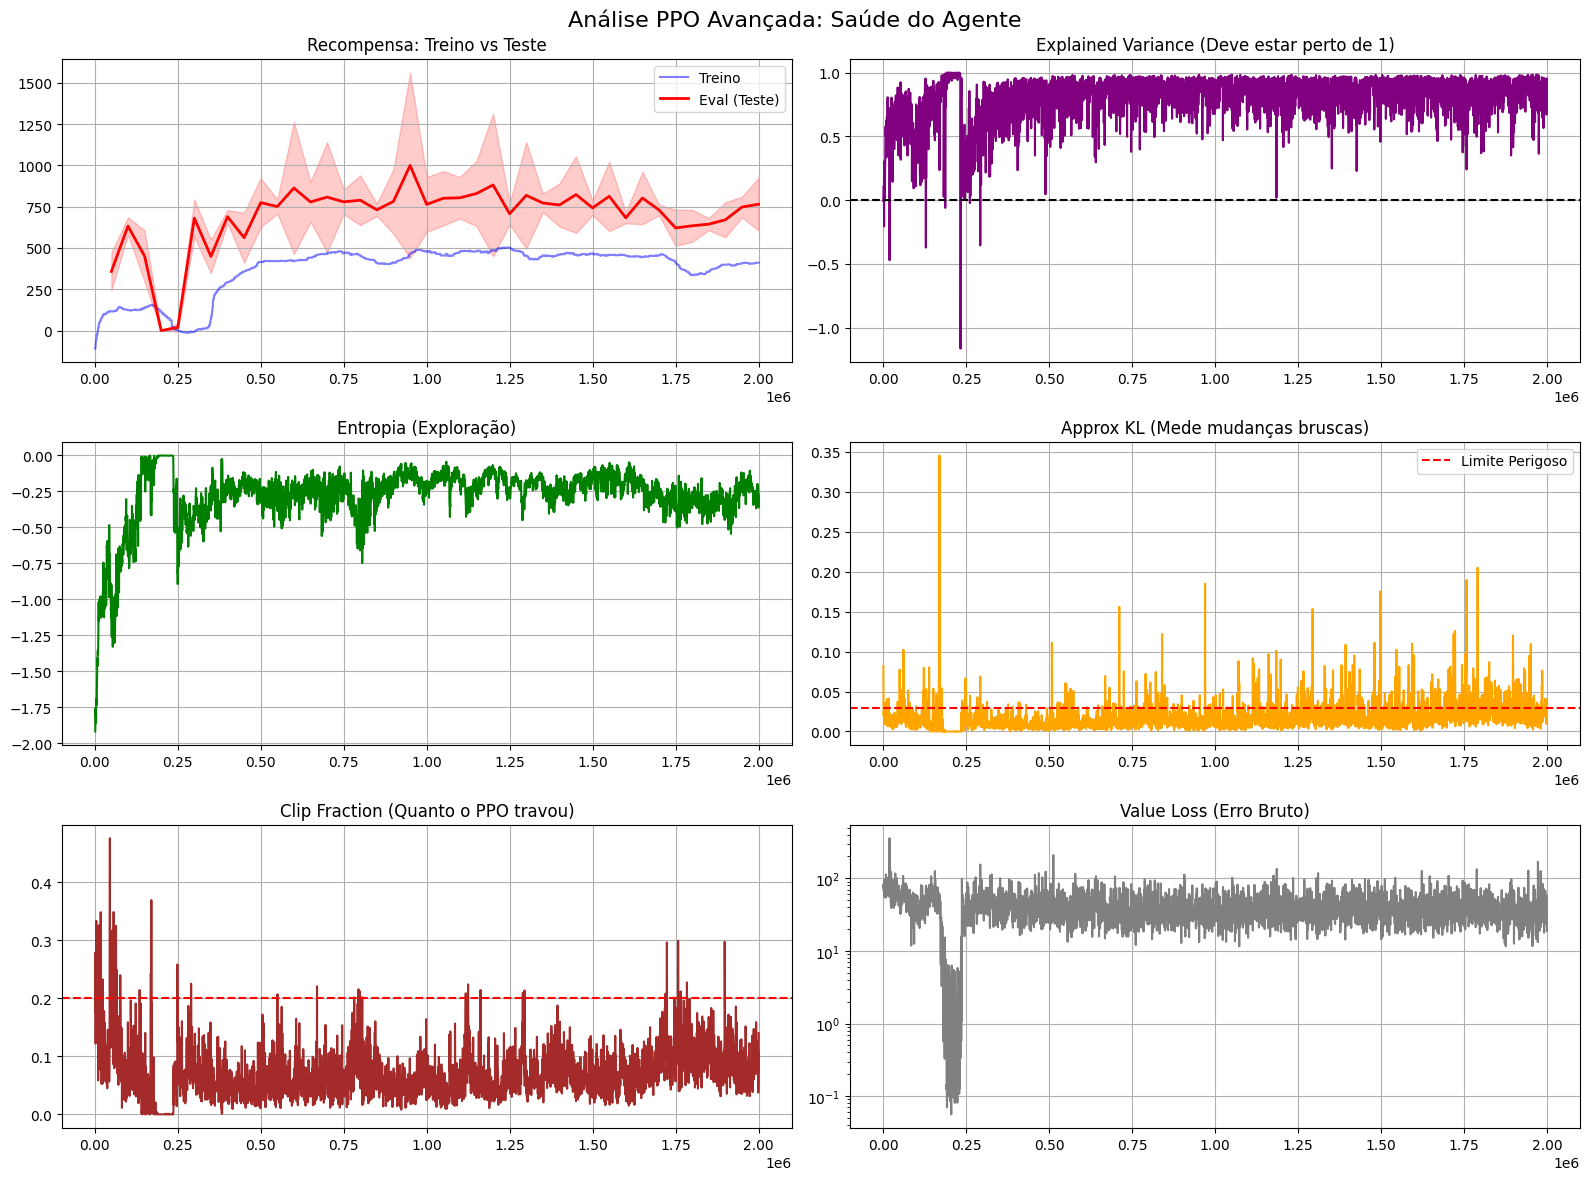


RELATÓRIO DE SAÚDE DO AGENTE (PPO)
Explained Variance Final: 0.8769
>>> BOM: O agente entende bem a pontuação futura.
Approx KL (Média recente): 0.02163
Clip Fraction (Média recente): 0.0781



In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

# --- CONFIGURAÇÃO ---
# ATENÇÃO: Substitui pelos teus caminhos reais
EVAL_PATH = "Ambiente_Enemies_Penalty/results/evaluations.npz" 
LOG_PATH = "Ambiente_Enemies_Penalty/PPO_1/events.out.tfevents.1765403403.diogo-Katana-15-B13VEK.26193.0" 

def load_eval_data(path):
    if not os.path.exists(path):
        print(f"ERRO: Ficheiro de eval não encontrado: {path}")
        return None, None, None
    data = np.load(path)
    return data['timesteps'], np.mean(data['results'], axis=1), np.std(data['results'], axis=1)

def load_tensorboard_data(path, tags):
    if not os.path.exists(path):
        print(f"ERRO: Log não encontrado: {path}")
        return {}
    ea = EventAccumulator(path)
    ea.Reload()
    data = {}
    valid_tags = ea.Tags()['scalars']
    for tag in tags:
        if tag in valid_tags:
            events = ea.Scalars(tag)
            data[tag] = ([e.step for e in events], [e.value for e in events])
    return data

def analyze_ppo():
    # 1. Carregar Dados
    eval_steps, eval_means, eval_stds = load_eval_data(EVAL_PATH)
    
    # Tags vitais para PPO
    tb_tags = [
        'rollout/ep_rew_mean',       # Performance
        'train/entropy_loss',        # Exploração
        'train/explained_variance',  # Inteligência do Crítico (Novo!)
        'train/approx_kl',           # Estabilidade da Mudança (Novo!)
        'train/clip_fraction',       # Agressividade do Learning Rate (Novo!)
        'train/value_loss'           # Erro bruto
    ]
    train_data = load_tensorboard_data(LOG_PATH, tb_tags)

    if eval_steps is None or not train_data: return

    # --- GRÁFICOS (Layout 3x2) ---
    fig, axs = plt.subplots(3, 2, figsize=(16, 12))
    fig.suptitle('Análise PPO Avançada: Saúde do Agente', fontsize=16)

    # 1. Reward (A Realidade)
    ax = axs[0, 0]
    if 'rollout/ep_rew_mean' in train_data:
        ax.plot(*train_data['rollout/ep_rew_mean'], label='Treino', color='blue', alpha=0.5)
    ax.plot(eval_steps, eval_means, label='Eval (Teste)', color='red', linewidth=2)
    ax.fill_between(eval_steps, eval_means - eval_stds, eval_means + eval_stds, color='red', alpha=0.2)
    ax.set_title('Recompensa: Treino vs Teste')
    ax.legend()
    ax.grid(True)

    # 2. Explained Variance (O Cérebro)
    ax = axs[0, 1]
    if 'train/explained_variance' in train_data:
        ax.plot(*train_data['train/explained_variance'], color='purple')
        ax.set_title('Explained Variance (Deve estar perto de 1)')
        ax.axhline(y=0, color='black', linestyle='--') # Linha do "chute aleatório"
        ax.grid(True)

    # 3. Entropy (A Curiosidade)
    ax = axs[1, 0]
    if 'train/entropy_loss' in train_data:
        ax.plot(*train_data['train/entropy_loss'], color='green')
        ax.set_title('Entropia (Exploração)')
        ax.grid(True)

    # 4. Approx KL (A Estabilidade)
    ax = axs[1, 1]
    if 'train/approx_kl' in train_data:
        ax.plot(*train_data['train/approx_kl'], color='orange')
        ax.set_title('Approx KL (Mede mudanças bruscas)')
        ax.axhline(y=0.03, color='red', linestyle='--', label='Limite Perigoso')
        ax.legend()
        ax.grid(True)

    # 5. Clip Fraction (O Travão)
    ax = axs[2, 0]
    if 'train/clip_fraction' in train_data:
        ax.plot(*train_data['train/clip_fraction'], color='brown')
        ax.set_title('Clip Fraction (Quanto o PPO travou)')
        ax.axhline(y=0.2, color='red', linestyle='--', label='Muitos Cortes')
        ax.grid(True)

    # 6. Value Loss
    ax = axs[2, 1]
    if 'train/value_loss' in train_data:
        ax.plot(*train_data['train/value_loss'], color='gray')
        ax.set_title('Value Loss (Erro Bruto)')
        ax.set_yscale('log')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    # --- RELATÓRIO DE TEXTO AVANÇADO ---
    print("\n" + "="*50)
    print("RELATÓRIO DE SAÚDE DO AGENTE (PPO)")
    print("="*50)

    # Análise Variance
    if 'train/explained_variance' in train_data:
        var_final = train_data['train/explained_variance'][1][-1]
        print(f"Explained Variance Final: {var_final:.4f}")
        if var_final < 0:
            print(">>> CRÍTICO: O agente está a 'chutar' valores. A rede não entende o jogo.")
            print("    Ação: Verificar recompensas ou aumentar tamanho da rede.")
        elif var_final > 0.8:
            print(">>> BOM: O agente entende bem a pontuação futura.")

    # Análise KL Divergence
    if 'train/approx_kl' in train_data:
        kl_mean = np.mean(train_data['train/approx_kl'][1][-100:]) # Média dos últimos 100
        print(f"Approx KL (Média recente): {kl_mean:.5f}")
        if kl_mean > 0.03:
            print(">>> ALERTA: Policy instável (Mudanças demasiado bruscas).")
            print("    Ação: REDUZIR o Learning Rate ou diminuir 'clip_range'.")
        elif kl_mean < 0.001:
            print(">>> ALERTA: Aprendizagem estagnada (Mudanças mínimas).")
            print("    Ação: AUMENTAR o Learning Rate.")

    # Análise Clip Fraction
    if 'train/clip_fraction' in train_data:
        clip_mean = np.mean(train_data['train/clip_fraction'][1][-100:])
        print(f"Clip Fraction (Média recente): {clip_mean:.4f}")
        if clip_mean > 0.2:
            print(">>> ALERTA: O PPO está a cortar muitas atualizações (>20%).")
            print("    Significa que o Learning Rate está demasiado alto para a estabilidade atual.")

    print("="*50 + "\n")

if __name__ == "__main__":
    analyze_ppo()

## Versão 2

In [23]:
import gc
import torch

# 1. Apagar as variáveis pesadas se elas existirem
objetos_para_apagar = ['model', 'vec_env', 'env', 'eval_env']

for obj in objetos_para_apagar:
    if obj in globals():
        del globals()[obj]
        print(f"Variável '{obj}' apagada.")

# 2. Forçar a recolha de lixo (Garbage Collection)
gc.collect()

# 3. Limpar cache da GPU (caso tenhas conseguido pôr o CUDA a funcionar)
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("Cache da GPU limpa.")

print("Memória limpa! Podes tentar criar o modelo agora.")

Variável 'model' apagada.
Variável 'vec_env' apagada.
Cache da GPU limpa.
Memória limpa! Podes tentar criar o modelo agora.


In [24]:
LOG_DIR = "./Ambiente_Enemies_Penalty_v3"
os.makedirs(LOG_DIR, exist_ok=True)

In [25]:
N_ENVS = 1

In [26]:
# Exemplo de como definir o 'params' antes de chamar a função
qrdqn_params = {
    # 1. Taxa de Aprendizagem (Learning Rate)
    # 1e-4 é o padrão "seguro" para Adam no Atari. 
    # Valores mais altos tornam o treino instável.
    "learning_rate": 1e-4,

    # 2. Buffer Size (Memória de Experiência)
    # CRÍTICO: O paper original usa 1.000.000. 
    # Se tiveres menos de 16GB de RAM, reduz para 100.000.
    # Quanto maior, mais estável é o treino (menos esquecimento).
    "buffer_size":40_000,  

    # 3. Batch Size
    # 32 é o número clássico para DQN/QR-DQN. Não aumentes isto no Atari.
    "batch_size": 32,

    # 4. Início da Aprendizagem (Learning Starts)
    # O agente joga 100.000 frames de forma aleatória antes de começar a treinar.
    # Isto enche o buffer com dados diversos para não criar vícios iniciais.
    "learning_starts": 10_000, 

    # 5. Frequência de Treino
    # Treina a cada 4 passos do ambiente.
    # Isto está alinhado com o "frame skip" padrão do Atari.
    "train_freq": 4,

    # 6. Atualização da Rede Alvo (Target Network)
    # Copia os pesos da rede de aprendizagem para a rede alvo a cada 1000 passos.
    # Ajuda a estabilizar o alvo móvel que a rede tenta atingir.
    "target_update_interval": 1000,

    # 7. Exploração (Epsilon Greedy)
    # exploration_fraction: Durante os primeiros 10% do treino, ele explora muito.
    # exploration_final_eps: Depois disso, ele explora apenas 1% do tempo (0.01).
    "exploration_fraction": 0.1, 
    "exploration_final_eps": 0.01,

    # 8. Otimização de Memória (Opcional mas recomendado)
    # Se True, torna o buffer mais lento, mas poupa MUITA RAM.
    "optimize_memory_usage": False,
    
    # 9. Argumentos da Política (Rede Neural)
    # Não precisas definir isto no params se passares diretamente na classe,
    # mas é bom saber: 'n_quantiles': 200 é o padrão do QR-DQN.

    # 10. TIMESTEPS_TOTAIS
    "total_timesteps": 2_000_000
}
# Como chamar:
# model, reset = load_qrdqn("meu_qrdqn_assault", env, qrdqn_params, "./logs/")
MODEL_PATH = os.path.join(LOG_DIR, "ppo_assault.zip")

In [27]:
env_fns = [
        make_callback_train(
                rank = i,
                seed = 42,
                LOG_DIR = LOG_DIR,
                wrapper_class = CustomAssaultWrapperEnemies,
                wrapper_kwargs = dict(
                        noise_level=0,
                        living_penalty=0,
                        shot_penalty=-0.5,
                        death_penalty=-25,
                        enemy_penalty_factor=-0.005)
                )
        for i in range(N_ENVS)
        ]

# 2. Transforma a lista num Ambiente Vetorizado Real
# É aqui que os processos paralelos são criados
vec_env = DummyVecEnv(env_fns)

# 3. APLICA O FRAME STACK (CRUCIAL!)
# Se não fizeres isto, o PPO vai receber imagens (210, 160, 1) e crashar
# porque a rede espera (210, 160, 4)
vec_env = VecFrameStack(vec_env, n_stack=4)

callback_treino = make_callback_test(LOG_DIR,N_ENVS)

model, reset_timesteps = load_qrdqn(MODEL_PATH, vec_env, qrdqn_params, LOG_DIR)

Nenhum modelo encontrado com o nome: ./Ambiente_Enemies_Penalty_v3/ppo_assault.zip
A criar um novo agente QR-DQN do zero...


In [28]:
# --- TREINO ---
model.learn(total_timesteps=qrdqn_params["total_timesteps"], progress_bar=True, callback = callback_treino, reset_num_timesteps=reset_timesteps)

# --- GUARDAR ---
model.save(MODEL_PATH)
print("Treino concluído e modelo guardado/atualizado!")

Output()

/home/diogo/anaconda3/envs/ISIA/lib/python3.10/site-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x7c4d1e646830> != <stable_baselines3.common.vec_env.vec_frame_stack.VecFrameStack object at 0x7c4d2042b1f0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=50000, episode_reward=401.80 +/- 114.22

Episode length: 576.90 +/- 133.06

New best mean reward!

Eval num_timesteps=100000, episode_reward=0.00 +/- 0.00

Episode length: 4651.67 +/- 3205.43

Eval num_timesteps=150000, episode_reward=312.90 +/- 89.15

Episode length: 571.57 +/- 128.79

Eval num_timesteps=200000, episode_reward=374.50 +/- 81.53

Episode length: 586.43 +/- 103.19

Eval num_timesteps=250000, episode_reward=474.60 +/- 151.98

Episode length: 903.97 +/- 400.01

New best mean reward!

Eval num_timesteps=300000, episode_reward=591.83 +/- 153.55

Episode length: 1693.07 +/- 1254.09

New best mean reward!

Eval num_timesteps=350000, episode_reward=519.03 +/- 103.20

Episode length: 849.30 +/- 189.78

Eval num_timesteps=400000, episode_reward=535.13 +/- 138.60

Episode length: 800.60 +/- 196.65

Eval num_timesteps=450000, episode_reward=563.50 +/- 122.34

Episode length: 872.97 +/- 197.24

Eval num_timesteps=500000, episode_reward=621.53 +/- 109.16

Episode length: 1346.10 +/- 402.84

New best mean reward!

Eval num_timesteps=550000, episode_reward=637.40 +/- 111.07

Episode length: 912.37 +/- 159.86

New best mean reward!

Eval num_timesteps=600000, episode_reward=589.83 +/- 145.81

Episode length: 785.30 +/- 151.22

Eval num_timesteps=650000, episode_reward=672.50 +/- 93.89

Episode length: 1035.47 +/- 173.08

New best mean reward!

Eval num_timesteps=700000, episode_reward=875.23 +/- 287.64

Episode length: 1373.13 +/- 533.97

New best mean reward!

Eval num_timesteps=750000, episode_reward=764.70 +/- 168.49

Episode length: 1039.80 +/- 239.65

Eval num_timesteps=800000, episode_reward=808.30 +/- 217.24

Episode length: 963.53 +/- 339.46

Eval num_timesteps=850000, episode_reward=897.10 +/- 212.79

Episode length: 1070.63 +/- 265.71

New best mean reward!

Eval num_timesteps=900000, episode_reward=911.30 +/- 254.37

Episode length: 1091.83 +/- 315.24

New best mean reward!

Eval num_timesteps=950000, episode_reward=791.07 +/- 141.15

Episode length: 956.63 +/- 166.88

Eval num_timesteps=1000000, episode_reward=1090.03 +/- 346.29

Episode length: 1480.50 +/- 466.73

New best mean reward!

Eval num_timesteps=1050000, episode_reward=961.70 +/- 528.83

Episode length: 1356.10 +/- 780.07

Eval num_timesteps=1100000, episode_reward=887.17 +/- 276.49

Episode length: 1267.03 +/- 365.53

Eval num_timesteps=1150000, episode_reward=874.77 +/- 156.71

Episode length: 994.47 +/- 224.69

Eval num_timesteps=1200000, episode_reward=851.90 +/- 198.29

Episode length: 950.07 +/- 243.15

Eval num_timesteps=1250000, episode_reward=983.43 +/- 272.33

Episode length: 1129.17 +/- 331.86

Eval num_timesteps=1300000, episode_reward=906.57 +/- 259.55

Episode length: 1126.63 +/- 354.04

Eval num_timesteps=1350000, episode_reward=1471.37 +/- 526.52

Episode length: 1957.87 +/- 846.84

New best mean reward!

Eval num_timesteps=1400000, episode_reward=850.80 +/- 256.81

Episode length: 972.73 +/- 312.47

Eval num_timesteps=1450000, episode_reward=758.67 +/- 174.16

Episode length: 872.83 +/- 185.17

Eval num_timesteps=1500000, episode_reward=1721.57 +/- 714.07

Episode length: 2169.83 +/- 1055.45

New best mean reward!

Eval num_timesteps=1550000, episode_reward=776.67 +/- 131.87

Episode length: 863.20 +/- 110.45

Eval num_timesteps=1600000, episode_reward=1135.43 +/- 353.28

Episode length: 1314.50 +/- 488.18

Eval num_timesteps=1650000, episode_reward=1859.60 +/- 636.12

Episode length: 2583.43 +/- 1047.40

New best mean reward!

Eval num_timesteps=1700000, episode_reward=1124.33 +/- 281.29

Episode length: 1226.93 +/- 349.89

Eval num_timesteps=1750000, episode_reward=1952.13 +/- 530.87

Episode length: 2381.73 +/- 752.69

New best mean reward!

Eval num_timesteps=1800000, episode_reward=1054.70 +/- 262.59

Episode length: 1196.77 +/- 339.72

Eval num_timesteps=1850000, episode_reward=1791.67 +/- 518.65

Episode length: 2581.53 +/- 930.08

Eval num_timesteps=1900000, episode_reward=1142.40 +/- 376.71

Episode length: 1310.50 +/- 487.24

Eval num_timesteps=1950000, episode_reward=1879.70 +/- 659.91

Episode length: 2986.37 +/- 1215.34

Eval num_timesteps=2000000, episode_reward=986.23 +/- 223.61

Episode length: 1005.67 +/- 263.82

Treino concluído e modelo guardado/atualizado!


In [ ]:
record_agent_video_mp4(
    model_path="Ambiente_Enemies_Penalty_v3/best_model/best_model.zip",
    video_path="./Ambiente_Enemies_Penalty_v3/video.mp4",
    frames_to_record=3000,
    wrapper_class=AssaultVisualWrapper,
    wrapper_kwargs=None,
)

A carregar o modelo: Ambiente_Enemies_Penalty_v3/best_model/best_model.zip


/home/diogo/anaconda3/envs/ISIA/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 10.75GB > 0.98GB
  warnings.warn(
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


A gravar vídeo em ./Ambiente_Enemies_Penalty_v3/video.mp4 ...
Vídeo guardado em: ./Ambiente_Enemies_Penalty_v3/video.mp4


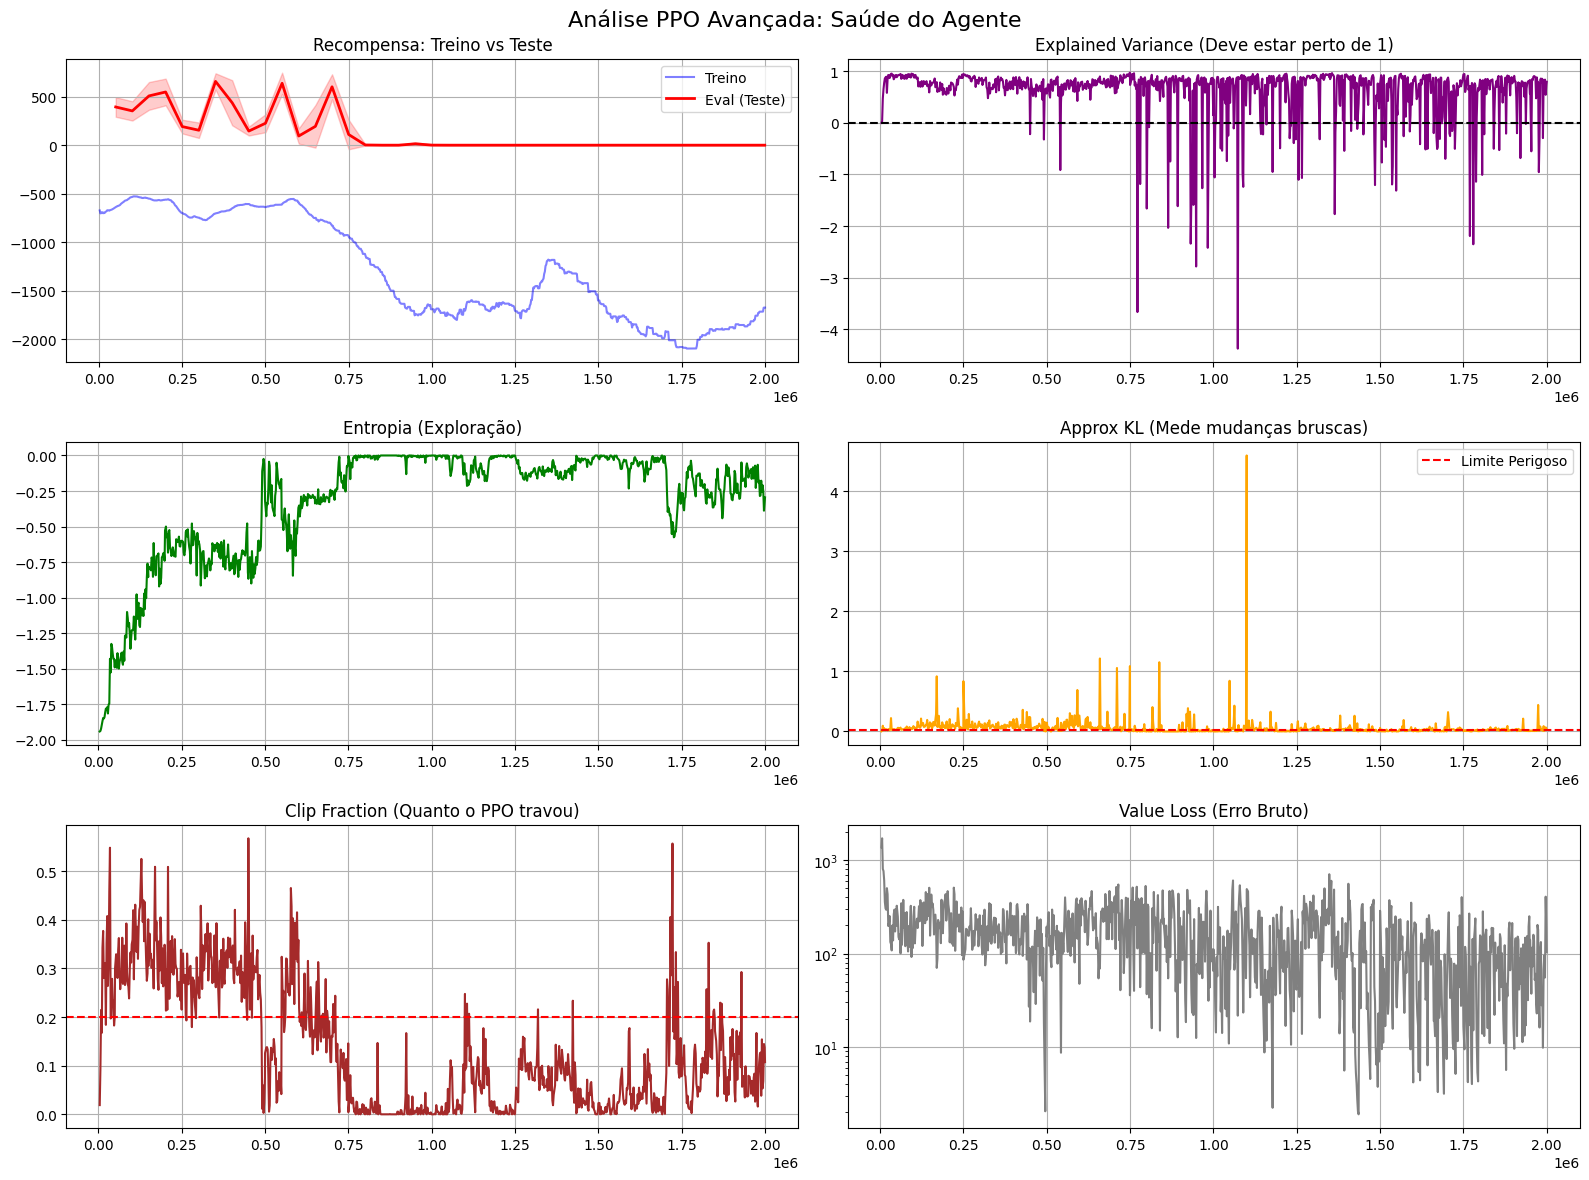


RELATÓRIO DE SAÚDE DO AGENTE (PPO)
Explained Variance Final: 0.7942
Approx KL (Média recente): 0.03252
>>> ALERTA: Policy instável (Mudanças demasiado bruscas).
    Ação: REDUZIR o Learning Rate ou diminuir 'clip_range'.
Clip Fraction (Média recente): 0.1066



In [34]:
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

# --- CONFIGURAÇÃO ---
# ATENÇÃO: Substitui pelos teus caminhos reais
EVAL_PATH = "Ambiente_Enemies_Penalty_v2/results/evaluations.npz" 
LOG_PATH = "Ambiente_Enemies_Penalty_v2/PPO_1/events.out.tfevents.1765417139.diogo-Katana-15-B13VEK.26193.1" 

def load_eval_data(path):
    if not os.path.exists(path):
        print(f"ERRO: Ficheiro de eval não encontrado: {path}")
        return None, None, None
    data = np.load(path)
    return data['timesteps'], np.mean(data['results'], axis=1), np.std(data['results'], axis=1)

def load_tensorboard_data(path, tags):
    if not os.path.exists(path):
        print(f"ERRO: Log não encontrado: {path}")
        return {}
    ea = EventAccumulator(path)
    ea.Reload()
    data = {}
    valid_tags = ea.Tags()['scalars']
    for tag in tags:
        if tag in valid_tags:
            events = ea.Scalars(tag)
            data[tag] = ([e.step for e in events], [e.value for e in events])
    return data

def analyze_ppo():
    # 1. Carregar Dados
    eval_steps, eval_means, eval_stds = load_eval_data(EVAL_PATH)
    
    # Tags vitais para PPO
    tb_tags = [
        'rollout/ep_rew_mean',       # Performance
        'train/entropy_loss',        # Exploração
        'train/explained_variance',  # Inteligência do Crítico (Novo!)
        'train/approx_kl',           # Estabilidade da Mudança (Novo!)
        'train/clip_fraction',       # Agressividade do Learning Rate (Novo!)
        'train/value_loss'           # Erro bruto
    ]
    train_data = load_tensorboard_data(LOG_PATH, tb_tags)

    if eval_steps is None or not train_data: return

    # --- GRÁFICOS (Layout 3x2) ---
    fig, axs = plt.subplots(3, 2, figsize=(16, 12))
    fig.suptitle('Análise PPO Avançada: Saúde do Agente', fontsize=16)

    # 1. Reward (A Realidade)
    ax = axs[0, 0]
    if 'rollout/ep_rew_mean' in train_data:
        ax.plot(*train_data['rollout/ep_rew_mean'], label='Treino', color='blue', alpha=0.5)
    ax.plot(eval_steps, eval_means, label='Eval (Teste)', color='red', linewidth=2)
    ax.fill_between(eval_steps, eval_means - eval_stds, eval_means + eval_stds, color='red', alpha=0.2)
    ax.set_title('Recompensa: Treino vs Teste')
    ax.legend()
    ax.grid(True)

    # 2. Explained Variance (O Cérebro)
    ax = axs[0, 1]
    if 'train/explained_variance' in train_data:
        ax.plot(*train_data['train/explained_variance'], color='purple')
        ax.set_title('Explained Variance (Deve estar perto de 1)')
        ax.axhline(y=0, color='black', linestyle='--') # Linha do "chute aleatório"
        ax.grid(True)

    # 3. Entropy (A Curiosidade)
    ax = axs[1, 0]
    if 'train/entropy_loss' in train_data:
        ax.plot(*train_data['train/entropy_loss'], color='green')
        ax.set_title('Entropia (Exploração)')
        ax.grid(True)

    # 4. Approx KL (A Estabilidade)
    ax = axs[1, 1]
    if 'train/approx_kl' in train_data:
        ax.plot(*train_data['train/approx_kl'], color='orange')
        ax.set_title('Approx KL (Mede mudanças bruscas)')
        ax.axhline(y=0.03, color='red', linestyle='--', label='Limite Perigoso')
        ax.legend()
        ax.grid(True)

    # 5. Clip Fraction (O Travão)
    ax = axs[2, 0]
    if 'train/clip_fraction' in train_data:
        ax.plot(*train_data['train/clip_fraction'], color='brown')
        ax.set_title('Clip Fraction (Quanto o PPO travou)')
        ax.axhline(y=0.2, color='red', linestyle='--', label='Muitos Cortes')
        ax.grid(True)

    # 6. Value Loss
    ax = axs[2, 1]
    if 'train/value_loss' in train_data:
        ax.plot(*train_data['train/value_loss'], color='gray')
        ax.set_title('Value Loss (Erro Bruto)')
        ax.set_yscale('log')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    # --- RELATÓRIO DE TEXTO AVANÇADO ---
    print("\n" + "="*50)
    print("RELATÓRIO DE SAÚDE DO AGENTE (PPO)")
    print("="*50)

    # Análise Variance
    if 'train/explained_variance' in train_data:
        var_final = train_data['train/explained_variance'][1][-1]
        print(f"Explained Variance Final: {var_final:.4f}")
        if var_final < 0:
            print(">>> CRÍTICO: O agente está a 'chutar' valores. A rede não entende o jogo.")
            print("    Ação: Verificar recompensas ou aumentar tamanho da rede.")
        elif var_final > 0.8:
            print(">>> BOM: O agente entende bem a pontuação futura.")

    # Análise KL Divergence
    if 'train/approx_kl' in train_data:
        kl_mean = np.mean(train_data['train/approx_kl'][1][-100:]) # Média dos últimos 100
        print(f"Approx KL (Média recente): {kl_mean:.5f}")
        if kl_mean > 0.03:
            print(">>> ALERTA: Policy instável (Mudanças demasiado bruscas).")
            print("    Ação: REDUZIR o Learning Rate ou diminuir 'clip_range'.")
        elif kl_mean < 0.001:
            print(">>> ALERTA: Aprendizagem estagnada (Mudanças mínimas).")
            print("    Ação: AUMENTAR o Learning Rate.")

    # Análise Clip Fraction
    if 'train/clip_fraction' in train_data:
        clip_mean = np.mean(train_data['train/clip_fraction'][1][-100:])
        print(f"Clip Fraction (Média recente): {clip_mean:.4f}")
        if clip_mean > 0.2:
            print(">>> ALERTA: O PPO está a cortar muitas atualizações (>20%).")
            print("    Significa que o Learning Rate está demasiado alto para a estabilidade atual.")

    print("="*50 + "\n")

if __name__ == "__main__":
    analyze_ppo()

# Outros

In [8]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

log_file = "assault_logs/PPO_1/events.out.tfevents.1765340029.diogo-Katana-15-B13VEK.18926.19"
event_acc = EventAccumulator(log_file)
event_acc.Reload()

# Isto imprime a lista de todas as tags que podes usar
print("Tags disponíveis para gráficos:")
for tag in event_acc.Tags()['scalars']:
    print(f" -> '{tag}'")

Tags disponíveis para gráficos:
 -> 'rollout/ep_len_mean'
 -> 'rollout/ep_rew_mean'
 -> 'time/fps'
 -> 'train/approx_kl'
 -> 'train/clip_fraction'
 -> 'train/clip_range'
 -> 'train/entropy_loss'
 -> 'train/explained_variance'
 -> 'train/learning_rate'
 -> 'train/loss'
 -> 'train/policy_gradient_loss'
 -> 'train/value_loss'


Encontrados 20 ficheiros de log.
A ler: assault_logs/PPO_1/events.out.tfevents.1765320435.diogo-Katana-15-B13VEK.18926.0...
A ler: assault_logs/PPO_1/events.out.tfevents.1765320896.diogo-Katana-15-B13VEK.18926.1...
A ler: assault_logs/PPO_1/events.out.tfevents.1765321364.diogo-Katana-15-B13VEK.18926.2...
A ler: assault_logs/PPO_1/events.out.tfevents.1765321905.diogo-Katana-15-B13VEK.18926.3...
A ler: assault_logs/PPO_1/events.out.tfevents.1765322353.diogo-Katana-15-B13VEK.18926.4...
A ler: assault_logs/PPO_1/events.out.tfevents.1765322799.diogo-Katana-15-B13VEK.18926.5...
A ler: assault_logs/PPO_1/events.out.tfevents.1765323219.diogo-Katana-15-B13VEK.18926.6...
A ler: assault_logs/PPO_1/events.out.tfevents.1765323645.diogo-Katana-15-B13VEK.18926.7...
A ler: assault_logs/PPO_1/events.out.tfevents.1765324100.diogo-Katana-15-B13VEK.18926.8...
A ler: assault_logs/PPO_1/events.out.tfevents.1765324557.diogo-Katana-15-B13VEK.18926.9...
A ler: assault_logs/PPO_1/events.out.tfevents.1765325000.

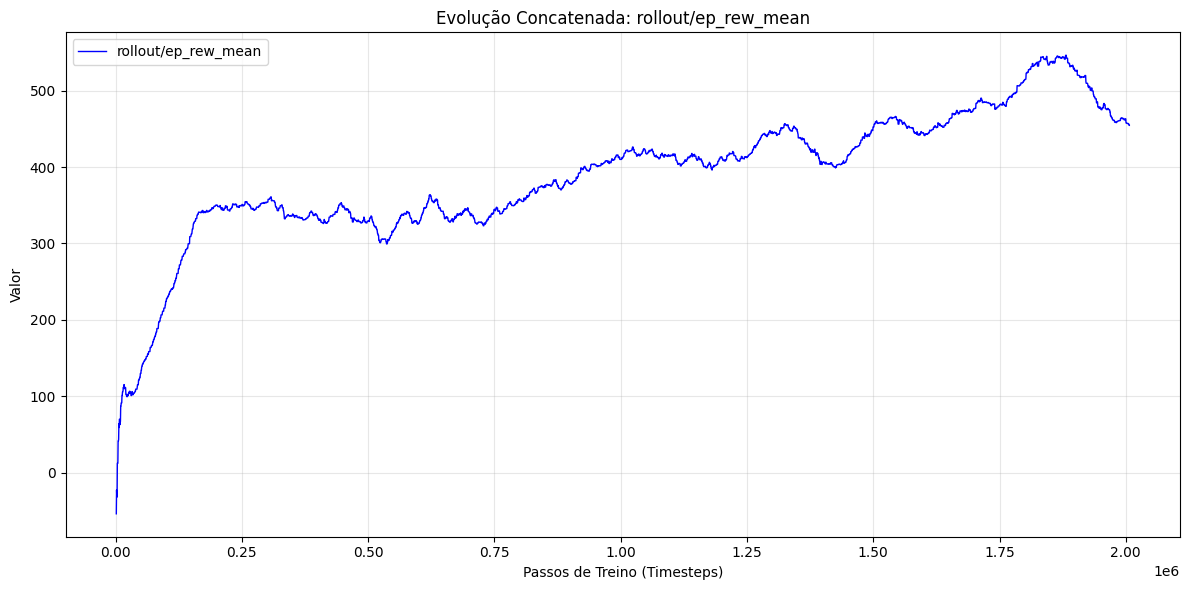

In [ ]:
import os
import glob
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

# 1. Configurações
# Define a pasta onde estão os 20 ficheiros (ex: "assault_logs/PPO_1/")
log_dir = "assault_logs/PPO_1/" 
tag = 'rollout/ep_rew_mean'  # A métrica que queres ver

# 2. Encontrar todos os ficheiros de eventos na pasta
# O padrão "events.out.tfevents.*" apanha todos os ficheiros desse tipo
event_files = glob.glob(os.path.join(log_dir, "events.out.tfevents.*"))
event_files.sort() # Ordenar os ficheiros por nome (opcional, mas ajuda na organização)

print(f"Encontrados {len(event_files)} ficheiros de log.")

all_steps = []
all_values = []

# 3. Ler cada ficheiro e juntar os dados
for file_path in event_files:
    print(f"A ler: {file_path}")
    try:
        event_acc = EventAccumulator(file_path)
        event_acc.Reload()
        
        if tag in event_acc.Tags()['scalars']:
            data = event_acc.Scalars(tag)
            
            # Guardar os passos e valores
            for x in data:
                all_steps.append(x.step)
                all_values.append(x.value)
        else:
            print(f" -> Aviso: A tag '{tag}' não existe neste ficheiro.")
            
    except Exception as e:
        print(f" -> Erro ao ler {file_path}: {e}")

# 4. Ordenar os dados pelos passos (Step)
# Isto é CRUCIAL para garantir que a linha do gráfico segue a ordem cronológica
if all_steps:
    # Cria pares (step, value), ordena pelo step, e desempacota de volta
    sorted_pairs = sorted(zip(all_steps, all_values))
    steps, values = zip(*sorted_pairs)

    # 5. Criar o Gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(steps, values, label=tag, color='blue', linewidth=1)
    
    plt.title(f"Evolução Concatenada: {tag}")
    plt.xlabel("Passos de Treino (Timesteps)")
    plt.ylabel("Valor")
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("Não foram encontrados dados para gerar o gráfico.")